In [34]:
import pandas as pd
from sklearn.metrics.cluster import homogeneity_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn import tree


In [2]:
data = pd.read_csv('cancer.csv')
data.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1,Class
0,7,4,5,10,2,10.00,3,8,2,malignant
1,5,3,4,1,4,1.00,3,1,1,benign
2,9,9,10,3,6,10.00,7,10,6,malignant
3,1,1,2,1,3,1.37,1,1,1,benign
4,5,7,9,8,6,10.00,8,10,1,malignant


In [3]:
X, y = data.drop('Class',axis=1) , data['Class']

In [4]:
y_color = y.map({' malignant':'r',' benign':'g'})
y = y.map({' malignant':0,' benign':1})


# PCA

In [5]:
pca = PCA(n_components=2)

In [6]:
pca_fitted = pca.fit_transform(X)

In [7]:
pca_fitted = pd.DataFrame(pca_fitted,columns = ['c1','c2']).join(y)
pca_fitted.head()

,c1,c2,Class
0,8.512006,-3.037445,0
1,-1.945706,1.255657,1
2,14.149909,1.588432,0
3,-5.403333,0.430676,1
4,13.084205,0.241268,0


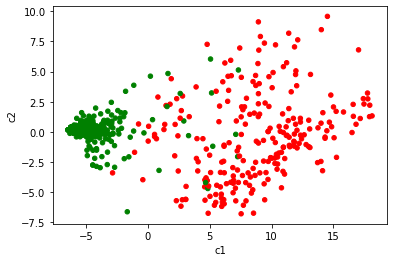

In [8]:
pca_fitted.plot.scatter('c1','c2',c=y_color)

In [9]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

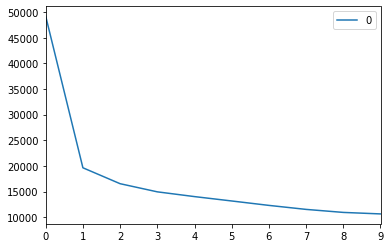

In [10]:
pd.DataFrame(inertia).plot()

# Check different hierarquical clustering:
## - Single, complete, average, ward
## - See if it is the same groups that appear


homogenity: 0.002367980525978337
v_measure: 0.004657869146744573


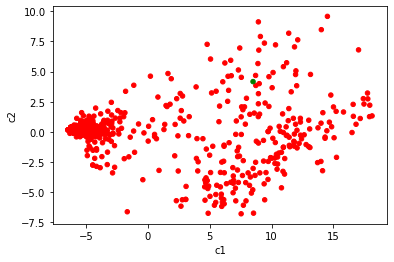

In [11]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
model.fit(X)
labels_single = model.labels_

print('homogenity:',homogeneity_score(y,labels_single))
print('v_measure:',v_measure_score(y,labels_single))

cmap = {0:'r',1:'g',2:'b',3:'c'}
c_single =[cmap[l] for l in labels_single]
pca_fitted.plot.scatter('c1','c2',c=c_single)

homogenity: 0.3455236995154179
v_measure: 0.3894613552653812


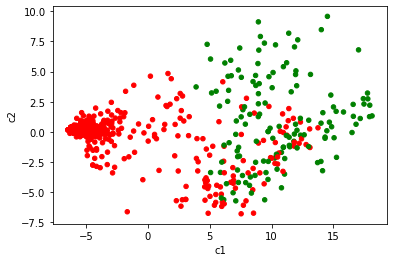

In [12]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
model.fit(X)
labels_complete = model.labels_

print('homogenity:',homogeneity_score(y,labels_complete))
print('v_measure:',v_measure_score(y,labels_complete))

cmap = {0:'r',1:'g',2:'b',3:'c'}
c_complete =[cmap[l] for l in labels_complete]
pca_fitted.plot.scatter('c1','c2',c=c_complete)

homogenity: 0.6614216317403844
v_measure: 0.673143838157139


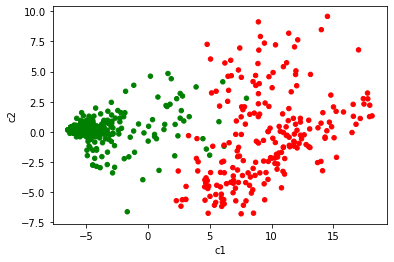

In [13]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
model.fit(X)
labels_avg = model.labels_

print('homogenity:',homogeneity_score(y,labels_avg))
print('v_measure:',v_measure_score(y,labels_avg))

cmap = {0:'r',1:'g',2:'b',3:'c'}
c_avg =[cmap[l] for l in labels_avg]
pca_fitted.plot.scatter('c1','c2',c=c_avg)

homogenity: 0.8110367493464317
v_measure: 0.7998335423475007


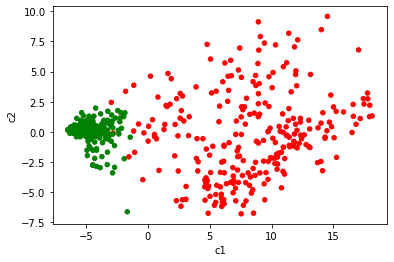

In [14]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X)
labels_ward = model.labels_

print('homogenity:',homogeneity_score(y,labels_ward))
print('v_measure:',v_measure_score(y,labels_ward))
cmap = {0:'r',1:'g',2:'b',3:'c'}
c_ward =[cmap[l] for l in labels_ward]
pca_fitted.plot.scatter('c1','c2',c=c_ward)

homogenity: 0.7394523693764153
v_measure: 0.7427241164299488


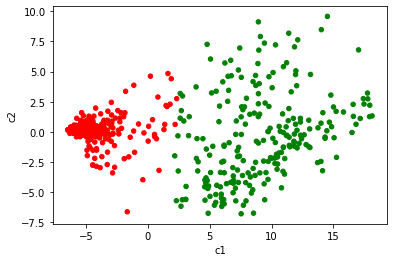

In [15]:
kmeans = KMeans(n_clusters=2,n_init=10).fit(X)
labels_km = kmeans.labels_

print('homogenity:',homogeneity_score(y,labels_km))
print('v_measure:',v_measure_score(y,labels_km))

cmap = {0:'r',1:'g',2:'b',3:'c'}
c_km =[cmap[l] for l in labels_km]
pca_fitted.plot.scatter('c1','c2',c=c_km)

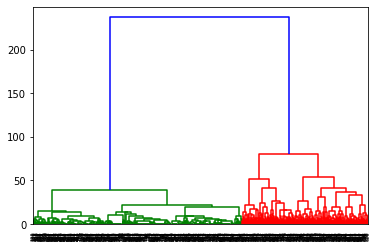

In [16]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))


## - TODO? Check stability by adding noise (how much noise until it changes?)

## Explain the best cluster with a decision tree

In [17]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, labels_ward)

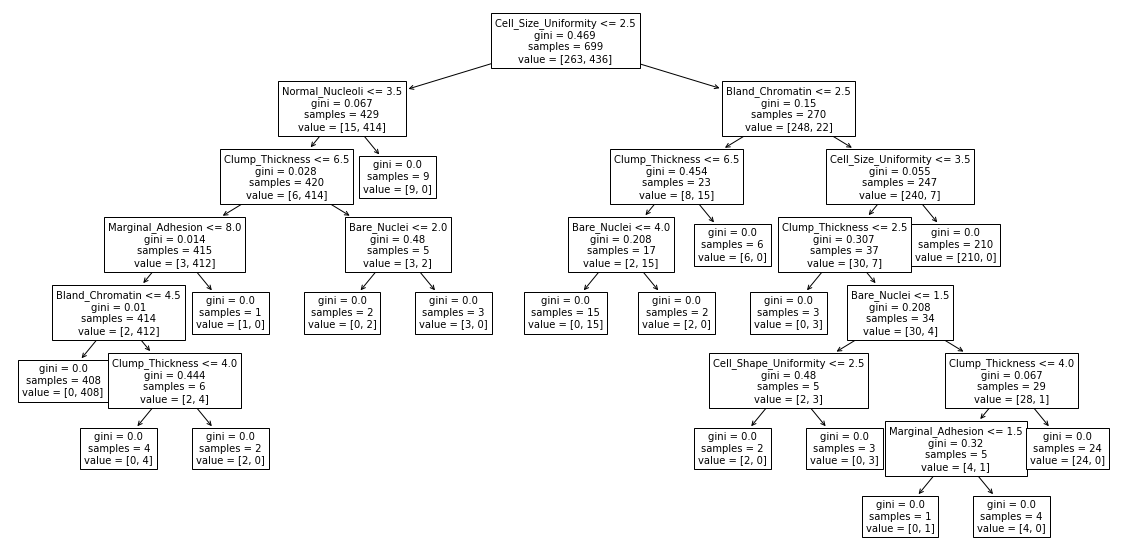

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
txt = tree.plot_tree(clf.fit(X, labels_ward),fontsize=10,ax=ax,feature_names=X.columns)

### Plot the fisrt and second best conditions that explain the predicted cluster

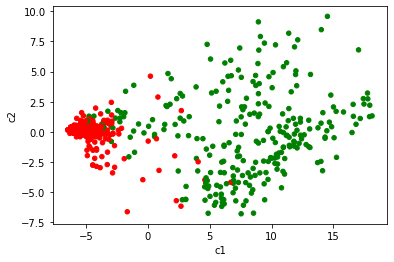

In [31]:
#Cell_Size_Uniformity<=2.5
pca_fitted.plot.scatter('c1','c2',c=(X.Cell_Size_Uniformity<=2.5).map({True:'r',False:'g'}))

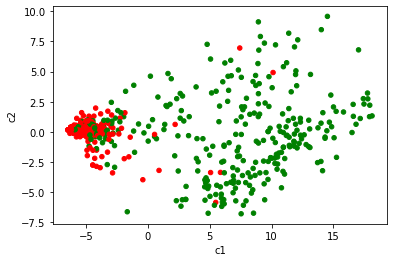

In [33]:
#Bland_Chromatin<=2.5
pca_fitted.plot.scatter('c1','c2',c=(X.Bland_Chromatin<=2.5).map({True:'r',False:'g'}))